## Exploratoration and Modeling

#### Jump To: [Splitting](#split) - [Explore](#explore) - [Modeling](#model)


In [1]:
#Basics
import numpy as np
import pandas as pd

#Viz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme(palette='colorblind')
plt.rcParams['font.size'] = '14'

#modeling tools
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#utils
import utils

## Acquire and Prep

In [2]:
#acquire
df = utils.get_co2_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 697 entries, 1964-05-15 to 2022-05-15
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yr      697 non-null    object 
 1   mn      697 non-null    object 
 2   co2     697 non-null    float64
dtypes: float64(1), object(2)
memory usage: 21.8+ KB


## Splitting <a class='anchor' id='split' />

I'm planning to do a cross-validation with a rolling 30 years. So for my first analysis, I still want to only use 30 years, so for this I'll pull that last 30, then do a split

In [4]:
print(f'{df.index.min()}\n{df.index.max()}')

1964-05-15 00:00:00
2022-05-15 00:00:00


In [5]:
#Set start and middle counts for tr/te
start = 12*30
middle = 12*10
#Grab train
tr_eda = df.iloc[:-middle,:] #long version for eda
tr_mod = df.iloc[-start:-middle,:] #shortened version for modeling
#Get test
te = df.iloc[-(middle):,:]


In [6]:
tr_mod.T

date,1992-06-15,1992-07-15,1992-08-15,1992-09-15,1992-10-15,1992-11-15,1992-12-15,1993-01-15,1993-02-15,1993-03-15,...,2011-08-15,2011-09-15,2011-10-15,2011-11-15,2011-12-15,2012-01-15,2012-02-15,2012-03-15,2012-04-15,2012-05-15
yr,1992,1992,1992,1992,1992,1992,1992,1993,1993,1993,...,2011,2011,2011,2011,2011,2012,2012,2012,2012,2012
mn,06,07,08,09,10,11,12,01,02,03,...,08,09,10,11,12,01,02,03,04,05
co2,359.05,356.82,354.8,352.81,353.11,353.96,355.2,356.5,356.97,358.18,...,390.25,389.05,388.98,390.3,391.86,393.13,393.42,394.43,396.51,396.96


In [7]:
te.T

date,2012-06-15,2012-07-15,2012-08-15,2012-09-15,2012-10-15,2012-11-15,2012-12-15,2013-01-15,2013-02-15,2013-03-15,...,2021-08-15,2021-09-15,2021-10-15,2021-11-15,2021-12-15,2022-01-15,2022-02-15,2022-03-15,2022-04-15,2022-05-15
yr,2012,2012,2012,2012,2012,2012,2012,2013,2013,2013,...,2021,2021,2021,2021,2021,2022,2022,2022,2022,2022
mn,06,07,08,09,10,11,12,01,02,03,...,08,09,10,11,12,01,02,03,04,05
co2,395.97,394.6,392.61,391.2,391.09,393.03,394.42,395.69,396.94,397.35,...,414.34,412.9,413.55,414.82,416.43,418.01,418.99,418.45,420.02,420.78


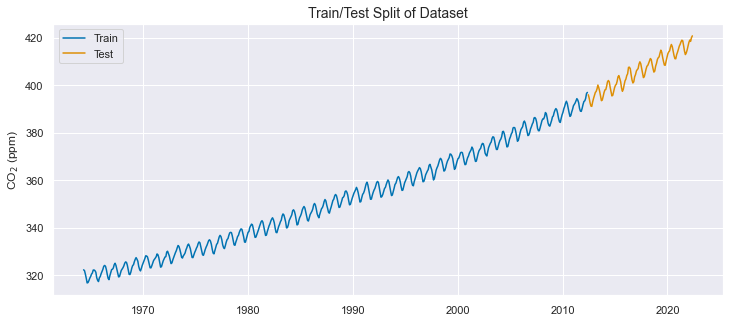

In [44]:
#Visualize the split
plt.figure(figsize=(12,5))
plt.plot(tr_eda.co2,label='Train');
plt.plot(te.co2,label='Test');
plt.legend();
plt.title('Train/Test Split of Dataset',size=14);
plt.ylabel('CO$_2$ (ppm)');

## Explore <a class='anchor' id='explore' />

OPT:
- modeled prediction accuracy (gen vs 2020/2021)
- Seasonal trend vs 2020/2021 seasonal

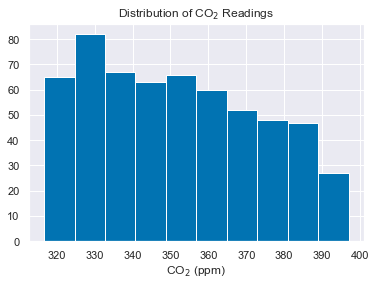

In [9]:
#distribution of values
tr_eda.co2.hist();
plt.title('Distribution of CO$_2$ Readings');
plt.xlabel('CO$_2$ (ppm)');

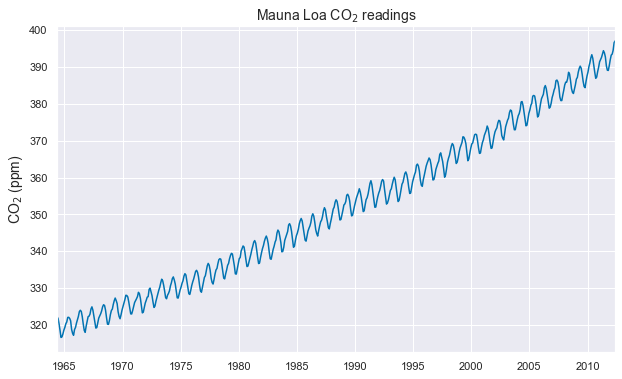

In [10]:
#time series plot
plt.figure(figsize=(10,6))
plt.plot(tr_eda.co2);
plt.title("Mauna Loa CO$_2$ readings",size=14);
plt.ylabel("CO$_2$ (ppm)",size=14);
plt.autoscale(enable=True, axis='x', tight=True); #makes x axis tight

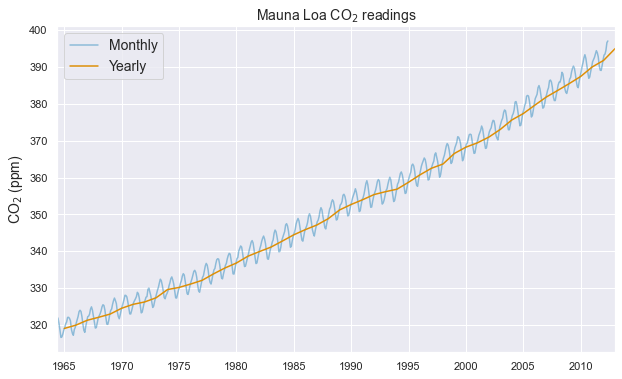

In [11]:
#Monthly/yearly graph
plt.figure(figsize=(10,6))
plt.plot(tr_eda.co2, alpha=.4, label='Monthly');
yrdf = tr_eda.resample('Y').mean()
plt.plot(yrdf,alpha=1, label='Yearly')
plt.title("Mauna Loa CO$_2$ readings",size=14);
plt.ylabel("CO$_2$ (ppm)",size=14);
plt.legend(fontsize=14)
plt.autoscale(enable=True, axis='x', tight=True); #makes x axis tight

### Seasonality

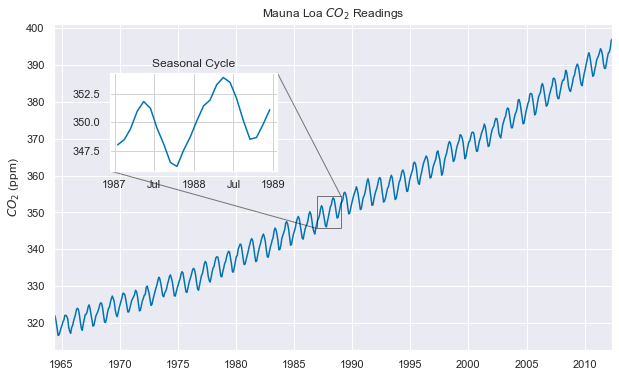

In [12]:
#Now repeat, but show seasonal inset
fig, ax = plt.subplots(figsize=[10,6])
# fig.set_size_inches(10,6)
#BIG PLOT
ax.plot(tr_eda.index,tr_eda.co2);
ax.set(title="Mauna Loa $CO_2$ Readings",ylabel="$CO_2$ (ppm)");
ax.autoscale(enable=True, axis='x', tight=True); #makes x axis tight
#INSET PLOT
# distance from left axis, distance from y axis, width, height
dims = [.1, .55, .3,.3]
axin = ax.inset_axes(dims)
#Plot
axin.plot(tr_eda.co2['1987':'1988'])
axin.set(title="Seasonal Cycle")
#inverse colors
axin.set(facecolor='white')
axin.grid(color='lightgrey')
# INSET XLabel Formatting
locator = mdates.AutoDateLocator(minticks=3,maxticks=7) #set acceptable tick range
formatter = mdates.ConciseDateFormatter(locator) #format with concise dates
axin.xaxis.set_major_locator(locator)
axin.xaxis.set_major_formatter(formatter)
# Draw lines to inset
ax.indicate_inset_zoom(axin,edgecolor='black')
plt.show()

##### Method 1 - average monthly variance - aggregated
- for each month, calculate average reading
- subtract that from total average reading

In [13]:
#Create dataframe w/ average monthly reading
m1_season = pd.DataFrame(tr_mod.groupby('mn').co2.mean())
#rename that column
m1_season.rename(columns={'co2':'avg_co2'},inplace=True)
# Get monthly variance
m1_season['seas_var'] = m1_season.avg_co2 - tr_mod.co2.mean()
m1_season['mn'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [14]:
m1_season

,avg_co2,seas_var,mn
mn,,,
01,374.1275,0.408917,Jan
02,374.9285,1.209917,Feb
03,375.6940,1.975417,Mar
04,377.1130,3.394417,Apr
05,377.6965,3.977917,May
06,375.2480,1.529417,Jun
07,373.7115,-0.007083,Jul
08,371.5935,-2.125083,Aug
09,369.9580,-3.760583,Sep


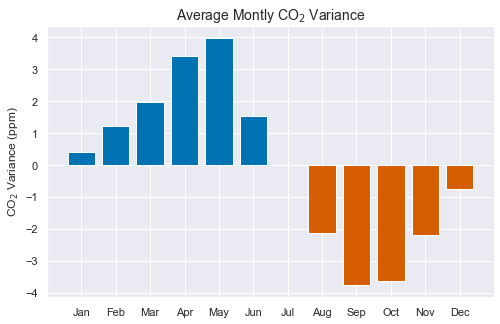

In [15]:
#Show Seasonality
plt.figure(figsize=(8,5))
plt.bar(range(1,13),m1_season.seas_var, color=np.where(m1_season.seas_var>0, '#0173b2', '#d55e00'))
plt.xticks(range(1,13),labels=m1_season.mn);
plt.ylabel("CO$_2$ Variance (ppm)");
plt.title("Average Montly CO$_2$ Variance",size=14);

##### Method 2 - seasonal_decompose

In [16]:
decomp = sm.tsa.seasonal_decompose(tr_mod.co2,period=12)
decomp.seasonal

date
1992-06-15    2.359295
1992-07-15    0.698571
1992-08-15   -1.584850
1992-09-15   -3.361122
1992-10-15   -3.415990
                ...   
2012-01-15    0.176224
2012-02-15    0.847825
2012-03-15    1.443242
2012-04-15    2.669317
2012-05-15    3.101488
Name: seasonal, Length: 240, dtype: float64

In [17]:
m2_season = pd.DataFrame({
    'y': decomp.observed,
    'trend': decomp.trend,
    'seasonal': decomp.seasonal,
    'resid': decomp.resid,
})
m2_season.tail(2)

,y,trend,seasonal,resid
date,,,,
2012-04-15,396.51,NaN,2.669317,NaN
2012-05-15,396.96,NaN,3.101488,NaN


In [18]:
#Do a resample and make sure the period was appropriate
tr_mod_eom = tr_mod.resample('m').mean()
decomp_eom = sm.tsa.seasonal_decompose(tr_mod_eom)
m2_season_eom = pd.DataFrame({
    'y': decomp_eom.observed,
    'trend': decomp_eom.trend,
    'seasonal': decomp_eom.seasonal,
    'resid': decomp_eom.resid,
})
last_full_year = str(tr_mod.index.year[-12]) #grab the year from 12 months back (makes sure we have a full year)

In [19]:

m2_season.seasonal[last_full_year]

date
2011-01-15    0.176224
2011-02-15    0.847825
2011-03-15    1.443242
2011-04-15    2.669317
2011-05-15    3.101488
2011-06-15    2.359295
2011-07-15    0.698571
2011-08-15   -1.584850
2011-09-15   -3.361122
2011-10-15   -3.415990
2011-11-15   -2.098030
2011-12-15   -0.835969
Name: seasonal, dtype: float64

In [20]:
m2_season_eom.seasonal[last_full_year] #RESAMPLING TO USE AUTO-PERIOD PRODUCED THE SAME RESULTS

date
2011-01-31    0.176224
2011-02-28    0.847825
2011-03-31    1.443242
2011-04-30    2.669317
2011-05-31    3.101488
2011-06-30    2.359295
2011-07-31    0.698571
2011-08-31   -1.584850
2011-09-30   -3.361122
2011-10-31   -3.415990
2011-11-30   -2.098030
2011-12-31   -0.835969
Freq: M, Name: seasonal, dtype: float64

##### Method 3 - Variance for each year - TIME-PERMITTING
- Method 2
  - Look at one year at a time:
  - get the mean for that year
  - get the monthly variance for each one in that year
  - see how Jan variance changes over time
  - Plot all variances over time (ex: 12 lines - 1 per month - those shows the variance over time

##### Plot Seasonaltiy - comparison of methods

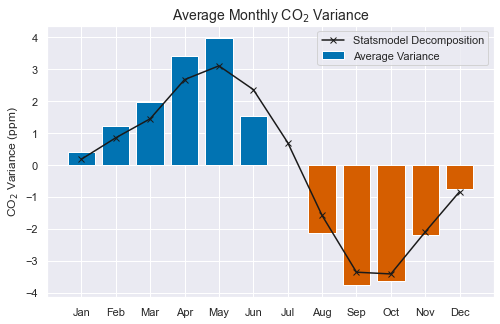

In [21]:
#Show Seasonality
plt.figure(figsize=(8,5))
plt.bar(range(1,13),m1_season.seas_var, color=np.where(m1_season.seas_var>0, '#0173b2', '#d55e00'),label='Average Variance')
plt.plot(range(1,13),m2_season.seasonal[last_full_year],label='Statsmodel Decomposition',marker='x',color='k')
plt.legend()
plt.xticks(range(1,13),labels=m1_season.mn);
plt.ylabel("CO$_2$ Variance (ppm)");
plt.title("Average Monthly CO$_2$ Variance",size=14);

## Modeling <a class='anchor' id='model' />

**NOTES on convo with Adam/Ryan - for modeling:** 20% more than time period

- percent accuracy at end of val, percent accuracy at end of test >> inform
  - see how far off from test the train only predictions would be
- Prophet

CrossValidation: can you build multiple models off of different training
- how well does one model perform over a long time period?
  - Greykite
- validation length should stay the same
- can either grow the train or shift it


##### Pull seasonal variance from data

In [22]:
## OLD METHOD - keeping for investigation later
# # Loop over months
# for m in m1_season.index:
#     #subset dataframe to that month - take the co2 readings minus the seasonality
#     tr_mod['adj'] = tr_mod[tr_mod.index.month == int(m)].co2 - m1_season.seas_var.loc[m]

In [23]:
tr_mod.shape

(240, 3)

In [24]:
#Join in the season_var column to our model dataset
# tr_mod = tr_mod.merge(m1_season[['seas_var']],on='mn') #THIS VERSION RESETS THE INDEX
#using 'left' instead of 'inner' preserves the index order of the left df (otherwise it reorders based of the key)
# then I can set the index from the left df
tr_mod = tr_mod.merge(m1_season[['seas_var']],how='left',on='mn').set_index(tr_mod.index)
#do the same for te
te_pred = te.merge(m1_season[['seas_var']],how='left',on='mn').set_index(te.index)
#create adjusted column
tr_mod['co2_adj'] = tr_mod.co2-tr_mod.seas_var

In [25]:
tr_mod.shape

(240, 5)

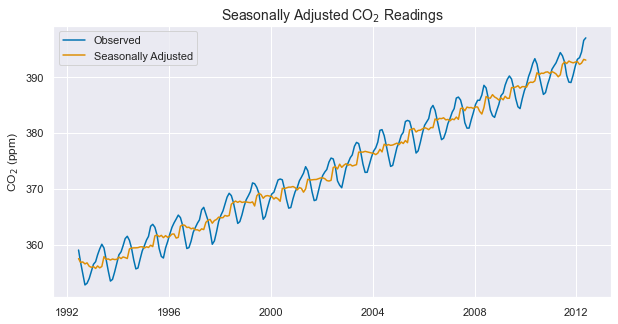

In [26]:
#Plot observed and seasonally adjusted
plt.figure(figsize=(10,5))
plt.plot(tr_mod.co2,label='Observed')
plt.plot(tr_mod.co2_adj,label='Seasonally Adjusted')
plt.ylabel("CO$_2$ (ppm)");
plt.title("Seasonally Adjusted CO$_2$ Readings",size=14);
plt.legend();

##### Model the Seasonally Adjusted data with:
- Holt
- Linear

In [27]:
te_pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2012-06-15 to 2022-05-15
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   yr        120 non-null    object 
 1   mn        120 non-null    object 
 2   co2       120 non-null    float64
 3   seas_var  120 non-null    float64
dtypes: float64(2), object(2)
memory usage: 4.7+ KB


In [28]:
#FOR MODELING - TOOLS REQUIRES FREQUENCY
te_pred = te_pred.resample('m').mean()
te_pred.info()
#do the same to tr_mod
tr_mod_eom = tr_mod.resample('m').mean()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2012-06-30 to 2022-05-31
Freq: M
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   co2       120 non-null    float64
 1   seas_var  120 non-null    float64
dtypes: float64(2)
memory usage: 2.8 KB


In [41]:
#create models
#Holt's LINEAR - optimized - manual seasonality
h_linear = Holt(tr_mod_eom.co2_adj,exponential=False, damped_trend=False).fit(optimized=True)
#Holt's EXPONENTIAL - optimized - manual seasonality
h_exp = Holt(tr_mod_eom.co2_adj,exponential=True, damped_trend=False).fit(optimized=True)
#Holt's Winter's EXPOTENTIAL SMOOTHING - additive - optimized
hw_ExpSmooth = ExponentialSmoothing(tr_mod_eom.co2,trend='add',seasonal='add',seasonal_periods=12).fit(optimized=True)

#GET PREDICTIONS - add back in seasonality
te_pred['h_linear'] = h_linear.predict(start=te_pred.index[0],end=te_pred.index[-1])
te_pred['h_linear_w_seas'] = te_pred.h_linear + te_pred.seas_var

te_pred['h_exp'] = h_exp.predict(start=te_pred.index[0],end=te_pred.index[-1])
te_pred['h_exp_w_seas'] = te_pred.h_exp + te_pred.seas_var

te_pred['hw_ExpSmooth'] = hw_ExpSmooth.predict(start=te_pred.index[0],end=te_pred.index[-1])


In [37]:
te_pred.tail()

,co2,seas_var,h_linear,h_linear_w_seas,h_exp,h_exp_w_seas,hw_ExpSmooth
date,,,,,,,
2022-01-31,418.01,0.408917,410.325994,410.734911,411.670003,412.078920,412.112762
2022-02-28,418.99,1.209917,410.475206,411.685123,411.834574,413.044490,412.913746
2022-03-31,418.45,1.975417,410.624418,412.599835,411.999210,413.974626,413.679251
2022-04-30,420.02,3.394417,410.773630,414.168047,412.163912,415.558328,415.098247
2022-05-31,420.78,3.977917,410.922842,414.900759,412.328680,416.306596,415.681749


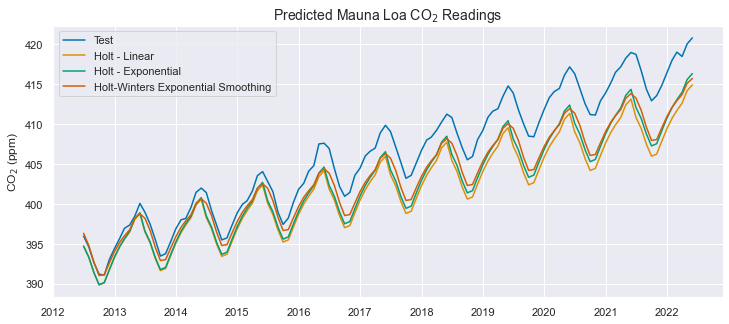

In [42]:
#Do some plotting
plt.figure(figsize=(12,5))
# plt.plot(tr_mod_eom.co2,label='Train')
plt.plot(te_pred.co2,label='Test')
plt.plot(te_pred.h_linear_w_seas, label='Holt - Linear')
plt.plot(te_pred.h_exp_w_seas, label='Holt - Exponential')
plt.plot(te_pred.hw_ExpSmooth, label='Holt-Winters Exponential Smoothing')
plt.title("Predicted Mauna Loa CO$_2$ Readings", size=14)
plt.ylabel("CO$_2$ (ppm)")
plt.legend()
plt.show()